In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# model name
model_name = 'model-lsr'

shuffle_clusters = False

# load the training data
data = DataModel('data-mtx-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .2, 
                 weight_compton=1, weight_non_compton=.75)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 1
ai.weight_pos_x = 2.5
ai.weight_pos_y = .5
ai.weight_pos_z = 2
ai.weight_energy = 1
ai.weight_e_cluster = .6
ai.weight_p_cluster = .4

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0000, limbs_l2=.0000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .003
    elif epoch < 110:
        return .001
    elif epoch < 140:
        return .0003
    elif epoch < 165:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
# #LOADING
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [6]:
#TRAINING

In [7]:
%%time
# balance the training data since there are too many background events
ai.data.balance_training = True

# start the training
ai.train(epochs=200, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

4274/4274 [==============================] - 10s 2ms/step - loss: 5.8585 - e_cluster_loss: 0.0335 - p_cluster_loss: 0.1537 - type_loss: 0.4129 - pos_x_loss: 0.1861 - pos_y_loss: 4.3082 - pos_z_loss: 0.0902 - energy_loss: 2.5643 - e_cluster__cluster_accuracy: 0.9746 - p_cluster__cluster_accuracy: 0.8740 - type__type_accuracy: 0.8126 - type__type_tp_rate: 0.8956

CPU times: user 5h 16min 24s, sys: 2min 33s, total: 5h 18min 57s
Wall time: 5h 31min 58s


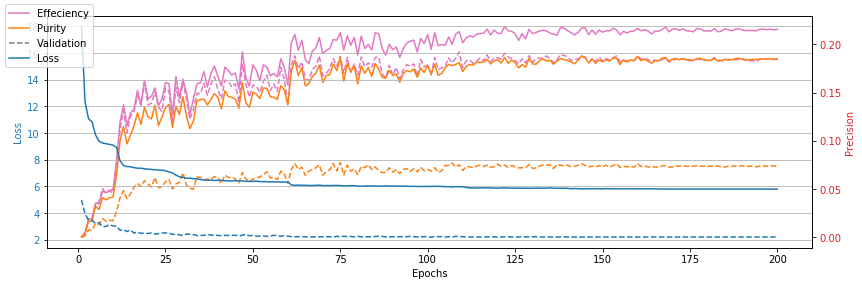

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [9]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        2.22258
    -Type:         0.49759 *  1.00 = 0.49759
    -Pos X:        0.04976 *  2.50 = 0.12441
    -Pos Y:        1.25075 *  0.50 = 0.62538
    -Pos Z:        0.02722 *  2.00 = 0.05443
    -Energy:       0.87717 *  1.00 = 0.87717
    -Cls e:        0.03102 *  0.60 = 0.01861
    -Cls p:        0.06248 *  0.40 = 0.02499
  Accuracy:     0.74879
    -Precision:    0.35262
    -Recall:       0.87485
    -Cls e rate:   0.94946
    -Cls p rate:   0.84782
  Efficiency:   0.19156
  Purity:       0.07721
  Euc mean:    11.30171
  Euc std:     20.72195
  Energy mean:  0.33104
  Energy std:   0.75936

Reco
  Accuracy:     0.69118
    -TP rate:      0.37851
  Efficiency:   0.05745
  Purity:       0.03047
  Euc mean:    20.59387
  Euc std:     43.40493
  Energy mean:  0.58215
  Energy std:   1.08863


In [9]:
# save the trained model
ai.save(file_name=model_name)